# DSMCER Notebook 9 - Feature Engineering 2

1. More feature extraction
   1. _Poll_: List some possible features
   2. Molecules
2. Feature selection
   1. By filtering
   2. _Exercise_: By Lasso selection
   3. Forward selection
   4. PCA
   5. _Exercise_: Interpretting the PCs

In [1]:
import time
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.ensemble

import codecarbon
import xgboost

# ! NEW
import sklearn.feature_selection
import sklearn.decomposition
import rdkit.Chem
import rdkit.Chem.Descriptors
import rdkit.Chem.rdMolDescriptors
import rdkit.ML.Descriptors.MoleculeDescriptors

***
***

## 1. More feature extraction

<font size=5><center> In our first SML lecture, we encoded nominal variables (the identity of DES agents) with OneHotEncoding:

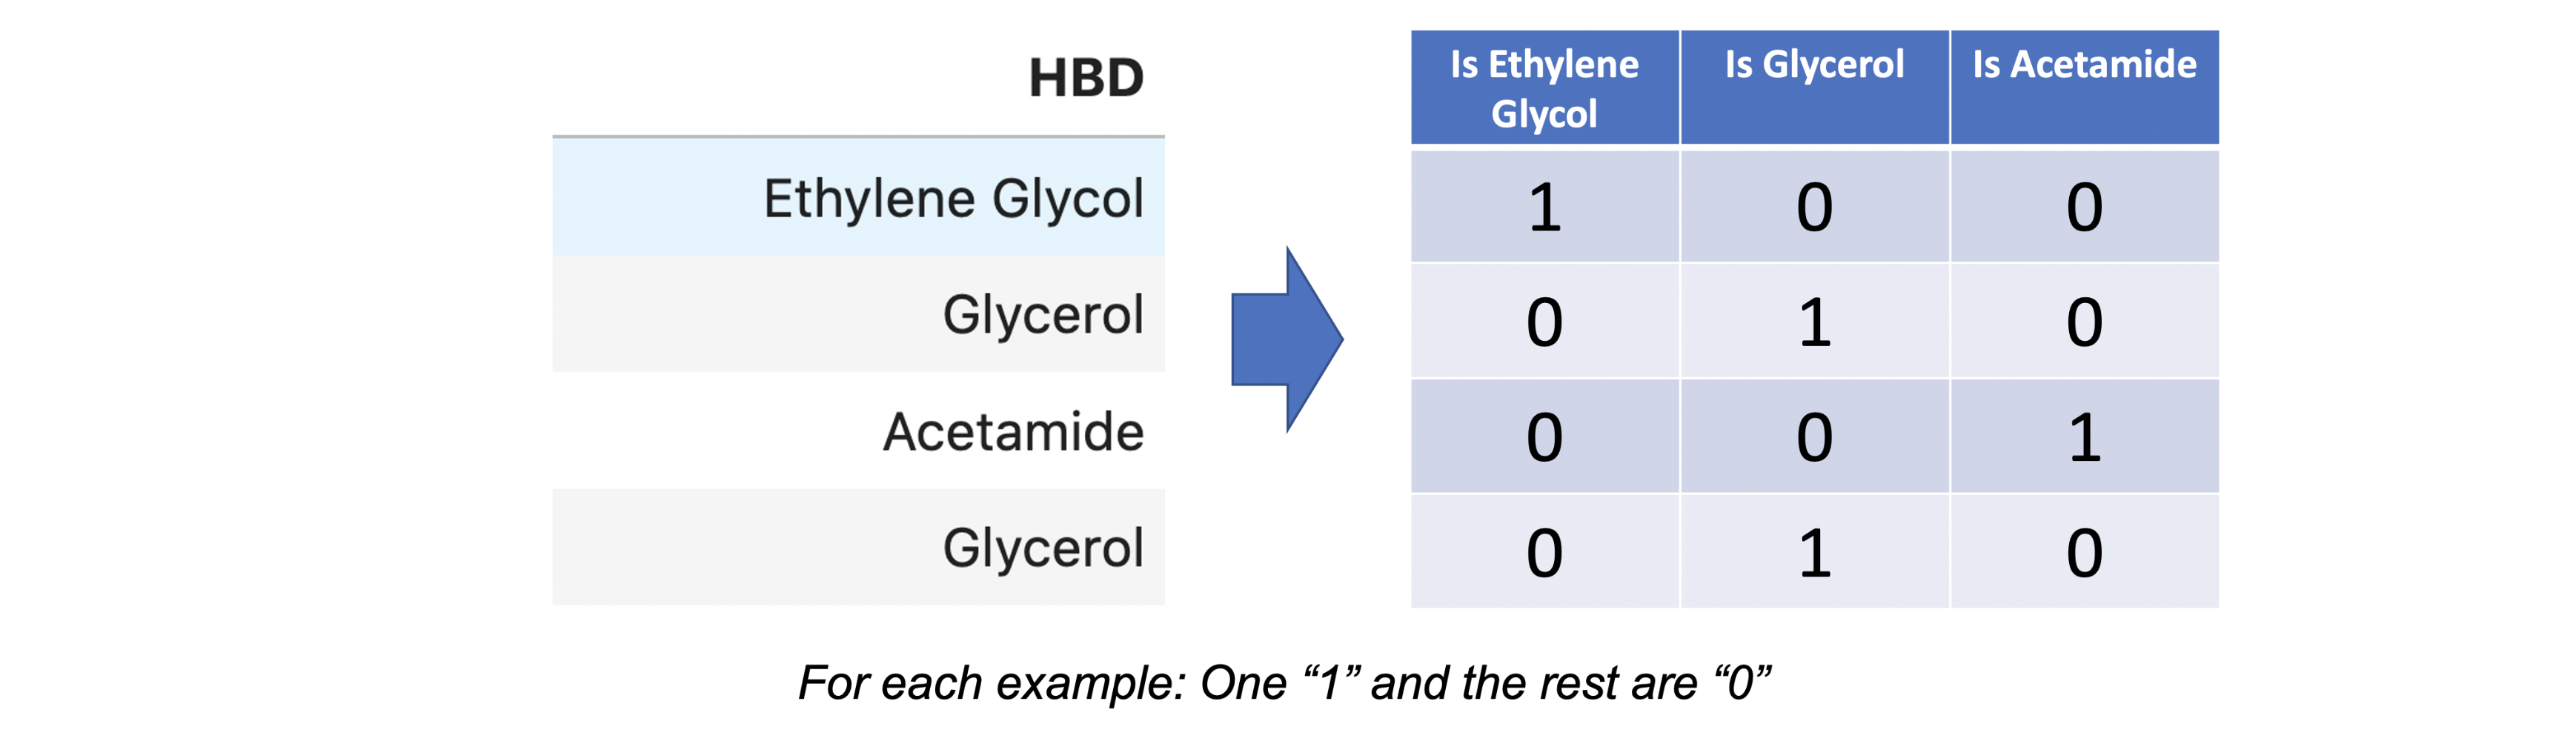

<font size=5><center> This was a rudimentary form of *feature selection*, but it is limited to the case when future examples __never have new nominal values__. 

***

### A. _Poll_: List some possible features

<font size=4> To create an SML model that would function __for new molecules not seen in training__ we had to engineer some new features that we expected to effect the DES mixture like molar mass and melting point. 
    
<font size=4><center> __Consider the following problem statement__: Create a predictor of human longevity.</center>
    
<font size=4>It would not be useful to OneHotEncode people, because the people we want to make predictions for are different from the ones we can take data for. __List some features we could extract from a person to try to predict their lifespan__?

***

### B. Molecules

<font size=5><center> __What features we can extract are task dependant__, but there are common things we can do for molecules and materials. 

<font size=4>__Hopefully working through this example of extracting features for molecules will give you a bigger picture of feature extraction for other examples__. It may also be that you end up working with molecules. Enter the `rdkit` molecules object:

In [2]:
help(rdkit.Chem.Mol)

Help on class Mol in module rdkit.Chem.rdchem:

class Mol(Boost.Python.instance)
 |  The Molecule class.
 |  
 |  In addition to the expected Atoms and Bonds, molecules contain:
 |    - a collection of Atom and Bond bookmarks indexed with integers
 |        that can be used to flag and retrieve particular Atoms or Bonds
 |        using the {get|set}{Atom|Bond}Bookmark() methods.
 |  
 |    - a set of string-valued properties. These can have arbitrary string
 |        labels and can be set and retrieved using the {set|get}Prop() methods
 |        Molecular properties can be tagged as being *computed*, in which case
 |          they will be automatically cleared under certain circumstances (when the
 |          molecule itself is modified, for example).
 |        Molecules also have the concept of *private* properties, which are tagged
 |          by beginning the property name with an underscore (_).
 |  
 |  Method resolution order:
 |      Mol
 |      Boost.Python.instance
 |      bui

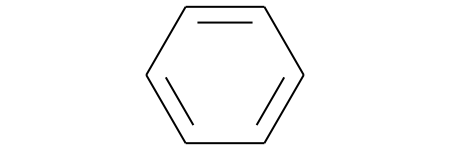

In [3]:
benzene = rdkit.Chem.MolFromSmiles('c1ccccc1')
benzene

<font size=4>*A note on "SMILES" stings. [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) (__S__ implified __M__ olecular-__I__ nput __L__ ine-__E__ ntry __S__ tring) defines the atoms in a molecule and the bonding pattern of the atoms. Please see the resource for more information.*

<font size=4>`rdkit` allows us to quickly extract many features from the SMILES string:

In [4]:
my_features = ['MolLogP', 'NumAromaticRings', 'MolWt']

In [5]:
calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(my_features)

In [6]:
calculator.CalcDescriptors(benzene)

(1.6866, 1, 78.11399999999999)

<font size=4>Instead of chosing specific descriptors, we might just extract them all... that is where the next section comes in ;)

In [7]:
all_descriptors = [name for name, _ in rdkit.Chem.Descriptors._descList]
print(all_descriptors)

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

In [8]:
calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(all_descriptors)

In [9]:
features = calculator.CalcDescriptors(benzene)
print(features)

(2.0, 2.0, 2.0, 2.0, 0.4426283718993647, 78.11399999999999, 72.06599999999999, 78.046950192, 30, 0, -0.062268570782092456, -0.062268570782092456, 0.062268570782092456, 0.062268570782092456, 0.3333333333333333, 0.5, 0.6666666666666666, 13.646993161855445, 10.379006838144555, 1.5737245910733604, -1.6942617326375449, 1.794093161855452, -1.4738931618554547, 4.985993161855456, 1.718006838144549, 3.000000000000001, 71.96100505779535, 4.242640687119286, 3.464101615137755, 3.464101615137755, 3.0, 2.0000000000000004, 2.0000000000000004, 1.1547005383792521, 1.1547005383792521, 0.6666666666666671, 0.6666666666666671, 0.38490017945975075, 0.38490017945975075, -0.78, 34.3994618804395, 3.4115708812260532, 1.6057694396735218, 0.5823992601400448, 37.43140311949697, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.39820241076966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.39820241076966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.39820241076966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

<font size=4>Each one of these __describes something physically interpretable about the molecule__. This type of feature is called a *descriptor*. 
    
<font size=4>Let's extract some descriptors for the whole dataset.

***

In [10]:
# load the data by downloading it
df = pd.read_csv('http://faculty.washington.edu/dacb/HCEPDB_moldata.zip').sample(500, random_state=201)

<font size=4>Use the smiles to compute features

In [11]:
my_features = ['FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR']
my_calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(my_features)

def smiles_to_descriptors(smiles, calculator=my_calculator):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    descriptors = calculator.CalcDescriptors(mol)
    return descriptors

In [12]:
descriptors = np.vstack(
    df['SMILES_str'].apply(smiles_to_descriptors))

[11:46:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 10 11 12 13 15 16 17 18 19 20 21 23 24 25
Traceback (most recent call last):
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/Chem/Lipinski.py", line 90, in <lambda>
    _fn = lambda x, y=_cfn: y(x)
Boost.Python.ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcFractionCSP3(NoneType)
did not match C++ signature:
    CalcFractionCSP3(RDKit::ROMol mol)
Traceback (most recent call last):
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/Chem/Lipinski.py", line 78, in HeavyAtom

<font size=4>__Notice how there were some errors?__ I won't dive into why, but suffice it to say that some of these descriptors don't work for certain types of molecules. In this case, RDKit gives back "-666" (spooky). There aren't really values, we want to replace these with `NaN` to make sure they don't slip through to the ML model

In [13]:
np.isclose(descriptors, -666.0).sum()

20

<font size=4>Add all the data back into a dataframe to make this easier

In [14]:
new_df = pd.DataFrame(descriptors)
new_df = new_df.rename(columns=lambda col_name: f"x{col_name}")

In [15]:
new_df['y'] = df['e_gap_alpha'].values

<font size=4>Fix all of the -666

In [16]:
new_df = new_df.replace(to_replace=-666.0, value=None).astype('Float64')

In [17]:
new_df.describe()

x0          x1          x2          x3          x4          x5  \
count  499.000000  499.000000  499.000000  499.000000  499.000000  499.000000   
mean     0.019788   27.396794    0.649299    2.853707    0.452906    0.468938   
std      0.028154    3.639761    0.746649    1.566671    0.642603    0.658995   
min      0.000000   16.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   25.000000    0.000000    2.000000    0.000000    0.000000   
50%      0.000000   28.000000    1.000000    3.000000    0.000000    0.000000   
75%      0.041667   30.000000    1.000000    4.000000    1.000000    1.000000   
max      0.142857   34.000000    3.000000    8.000000    3.000000    4.000000   

               x6          x7          x8          x9  ...         x11  \
count  499.000000  499.000000  499.000000  499.000000  ...  499.000000   
mean     0.921844    1.887776    3.859719    5.747495  ...    0.649299   
std      0.852532    1.178553    1.250044    1.232251  ...    0.746649   
min      0.000000    0.000000    0.000000    2.000000  ...    0.000000   
25%      0.000000    1.000000    3.000000    5.000000  ...    0.000000   
50%      1.000000    2.000000    4.000000    6.000000  ...    1.000000   
75%      1.000000    3.000000    5.000000    7.000000  ...    1.000000   
max      4.000000    5.000000    8.000000    9.000000  ...    3.000000   

              x12         x13    x14    x15    x16         x17         x18  \
count  499.000000  499.000000  499.0  499.0  499.0  499.000000  499.000000   
mean     5.206413    1.368737    0.0    0.0    0.0    6.669339    5.187807   
std      1.785562    0.833718    0.0    0.0    0.0    1.010428    1.933561   
min      1.000000    0.000000    0.0    0.0    0.0    4.000000   -3.671000   
25%      4.000000    1.000000    0.0    0.0    0.0    6.000000    3.978200   
50%      5.000000    1.000000    0.0    0.0    0.0    7.000000    5.353900   
75%      6.000000    1.000000    0.0    0.0    0.0    7.000000    6.691600   
max     12.000000    3.000000    0.0    0.0    0.0    9.000000    9.648000   

              x19           y  
count  499.000000  500.000000  
mean   118.177697    1.900399  
std     16.167400    0.407654  
min     61.444700    0.800672  
25%    107.740500    1.616958  
50%    120.813000    1.863972  
75%    131.169050    2.181222  
max    146.188000    3.002850  

[8 rows x 21 columns]

<font size=5><center>__Why don't we just use all of these features...?__

***

## 2. Feature Selection

<font size=4> One of the first things we often do is handle Null values. The ML model cannot deal with Null values. __We have a few options:__
    
1. <font size=4> Remove the datapoints that have nans. This is a good choice if there are only a few or you have __a lot__ of data
    
2. <font size=4> __Impute them__, for example by filling the Null values with the average over the rest of the data. We will not cover this explicity but if you have lots of Null values or a small dataset, it may be worth it. See more information [here](https://scikit-learn.org/stable/modules/impute.html|) 

In [18]:
new_df.isna().any(axis=1).sum()

1

<font size=4>There is only a single example in the dataset with NaN values, let's just drop them.

In [19]:
new_df = new_df.dropna()

In [20]:
new_df.shape

(499, 21)

<font size=4>We are doing machine learning. Remember __we must always__ save a test set and put it aside until the end. For a goal of "Predict energy gap for new compounds" a random split is likely sufficient, assuming we are not using new elements in the future. 

In [21]:
dev, test = sklearn.model_selection.train_test_split(new_df, test_size=.15, random_state=1)

<font size=5><center>Feature selection is concerned with __determining if any of our features are not useful or just extra noise.__

<font size=3> Let's look at a visual to get an idea:

/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, t

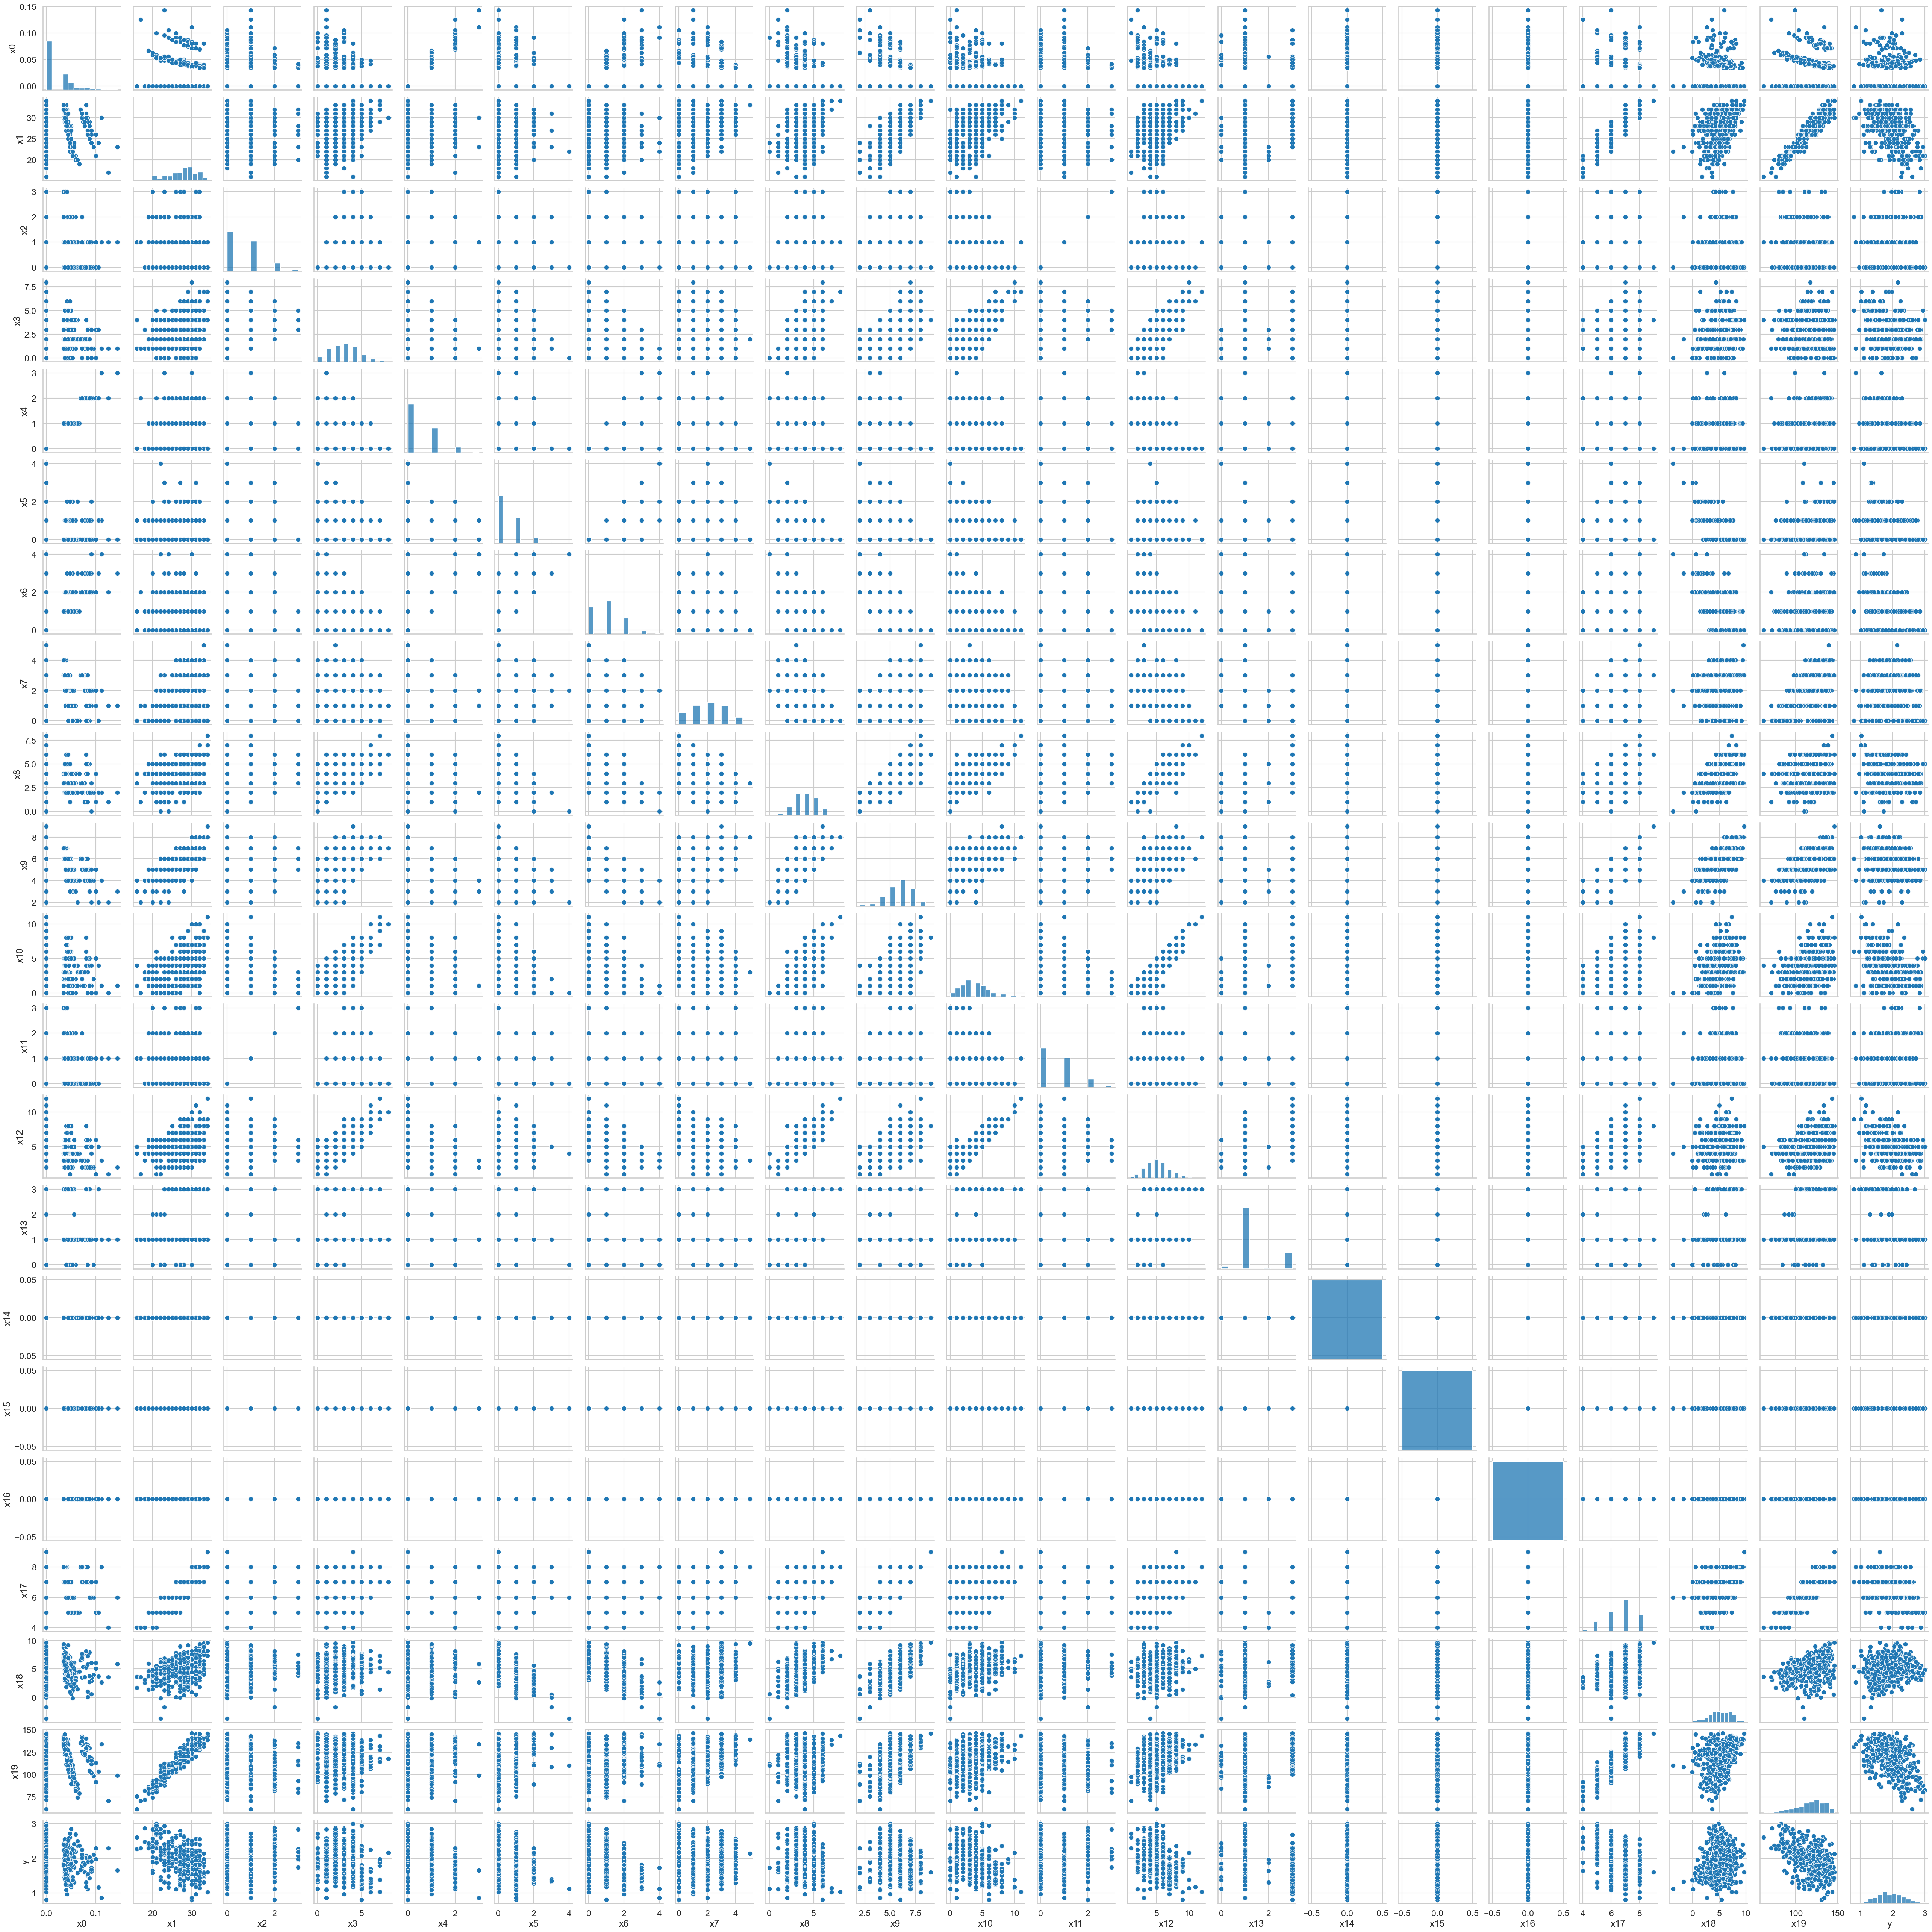

In [22]:
sns.pairplot(dev)

<font size=4>There are clearly some relationships to observe:

- <font size=4> $x16$ takes on only a single value in the whole dataset

- <font size=4> $x1$ and $x19$ are highly correlated

### A. By filtering

<font size=5><center>Before we do anything clever we can __just compute some measures of the data itself independant of any ML model__. We can use these to filter out some features.

<font size=4>Which data are related to the target according for example pearson correlation coefficient? There are other measures of correlation, see [here](https://www.analyticsvidhya.com/blog/2021/09/different-type-of-correlation-metrics-used-by-data-scientist/).

In [23]:
dev.corr(method='pearson')['y']

x0    -0.168364
x1    -0.453114
x2     0.049438
x3    -0.193466
x4    -0.188153
x5    -0.341558
x6    -0.406550
x7    -0.030942
x8    -0.029486
x9    -0.060224
x10   -0.269569
x11    0.049438
x12   -0.400135
x13   -0.239472
x14         NaN
x15         NaN
x16         NaN
x17   -0.426723
x18    0.210506
x19   -0.475648
y      1.000000
Name: y, dtype: float64

<font size=4>There is a low hanging fruit here - features 14 15 and 16 have `NaN` correlation. This means the pearson-r mathematically could not be calculate. These are the features that are the same value for the full dataset, and we can definately remove them.

In [24]:
dev = dev.drop(columns=['x14', 'x15', 'x16'])
test = test.drop(columns=['x14', 'x15', 'x16'])

<font size=4>We might also chose to remove features with __low correlation__:

In [25]:
dev.corr(method='pearson')['y'].abs() < 0.03

x0     False
x1     False
x2     False
x3     False
x4     False
x5     False
x6     False
x7     False
x8      True
x9     False
x10    False
x11    False
x12    False
x13    False
x17    False
x18    False
x19    False
y      False
Name: y, dtype: bool

In [26]:
features_to_remove = ['x2', 'x11']

In [27]:
dev.drop(columns=features_to_remove)

x0    x1   x3   x4   x5   x6   x7   x8   x9  x10  x12  x13  x17  \
291  0.037037  32.0  3.0  1.0  0.0  1.0  4.0  3.0  7.0  4.0  5.0  1.0  8.0   
404  0.038462  31.0  4.0  1.0  0.0  1.0  2.0  5.0  7.0  4.0  5.0  1.0  8.0   
237       0.0  27.0  2.0  0.0  0.0  0.0  3.0  3.0  6.0  2.0  3.0  1.0  6.0   
215       0.0  29.0  5.0  0.0  0.0  0.0  2.0  4.0  6.0  5.0  6.0  3.0  6.0   
419      0.05  28.0  5.0  1.0  1.0  2.0  2.0  3.0  5.0  6.0  8.0  1.0  7.0   
..        ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
256  0.043478  26.0  3.0  1.0  0.0  1.0  1.0  3.0  4.0  2.0  3.0  3.0  5.0   
72   0.034483  32.0  3.0  1.0  0.0  1.0  4.0  3.0  7.0  1.0  3.0  1.0  8.0   
397       0.0  28.0  3.0  0.0  0.0  0.0  2.0  4.0  6.0  5.0  5.0  3.0  6.0   
236       0.0  27.0  4.0  0.0  1.0  1.0  3.0  2.0  5.0  4.0  5.0  1.0  6.0   
37        0.0  28.0  4.0  0.0  0.0  0.0  2.0  5.0  7.0  6.0  7.0  1.0  7.0   

        x18       x19         y  
291    7.93  137.8407  1.585444  
404  6.0549  126.7597   1.71982  
237  5.8134   114.432  2.791592  
215  6.1616  115.6407  1.754235  
419  0.6498   118.197  1.458394  
..      ...       ...       ...  
256  3.7704  105.4877  1.976199  
72   6.3335  133.1724  1.810439  
397   7.698   115.843  2.100259  
236  2.0516     112.3  2.028733  
37   6.8172  120.7747    2.2139  

[424 rows x 16 columns]

<font size=4>We have 15 features remaining after filtering!

***

<font size=5><center>Note that __removing features with correlation cannot capture nonlinear relationships__! Consider the following...

In [28]:
x = np.linspace(0,np.pi)
y = np.sin(x)

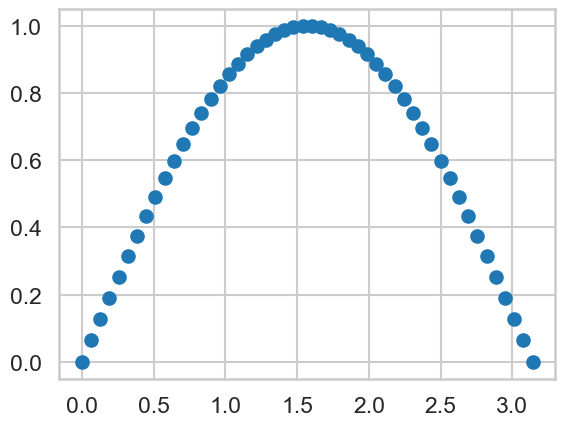

In [29]:
fig, ax = plt.subplots()
ax.scatter(x,y)

In [30]:
print(f'Pearson corr for this sin data: {scipy.stats.pearsonr(x,y)}')

Pearson corr for this sin data: (3.885780586188048e-16, 0.9999999999999972)


<font size=5><center>Clearly there is a relationship, but pearson doesn't think so, so be careful with this method.

***

### B. _Exercise_: By LASSO selection

<font size=4>Remember L1 regression (LASSO)? It can be used to select features.

In [31]:
train, val = sklearn.model_selection.train_test_split(new_df, test_size=.15, random_state=1)

In [32]:
def get_X_y(df):
    x_columns = [c for c in df.columns if 'x' in c]
    
    return df[x_columns].values, df['y'].to_numpy().reshape(-1,1)

In [33]:
train_X, train_y = get_X_y(train)
val_X, val_y = get_X_y(val)

In [34]:
scaler = sklearn.preprocessing.StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
val_X_scaled = scaler.transform(val_X)

<font size=4>Choose a value of `alpha` and train a LASSO model on the dev set. What are the weights (`model._coef`) of the model? Change `alpha` and retrain. What do you observe? (*Hint: start from a very low alpha*)

> <span style='color:red'> remove for lec


In [35]:
model = sklearn.linear_model.Lasso(alpha=.1)
model.fit(train_X_scaled, train_y)
print(f"Model weights: {model.coef_}")

Model weights: [-0.         -0.01463812  0.         -0.         -0.         -0.
 -0.07660868 -0.         -0.         -0.         -0.          0.
 -0.06794186 -0.          0.          0.          0.         -0.
  0.         -0.04874122]


In [36]:
model = sklearn.linear_model.Lasso(alpha=.05)
model.fit(train_X_scaled, train_y)
print(f"Model weights: {model.coef_}")

Model weights: [-0.         -0.08756618 -0.         -0.         -0.         -0.
 -0.14961543 -0.          0.          0.         -0.         -0.
 -0.12571651 -0.00073454  0.          0.          0.         -0.
  0.         -0.        ]


<font size=4>Note the "null model" of guessing the dev set mean.

In [37]:
null_error = np.abs(val_y - train_y.mean()).mean()
print(null_error)

0.30267898364942575


<font size=4>How good is our model?

In [38]:
sklearn.metrics.mean_absolute_error(val_y, model.predict(val_X_scaled))

0.22455293656538808

<font size=4>Not much better... this is the reason that high alpha returns all 0s for this application. The linear model is not much better than the null model, so __even a small amount of regularization pushes the model to guess the mean__.

<font size=4>When the problem is __highly nonlinear__ or when the __features we are starting with are just not good in the first place__, Lasso is not very helpful.

***

### C. By forward selection

<font size=5><center>We can overcome the linearity assumptions of filtering and Lasso with __brute force__.

<font size=4>Here we use a nonlinear model, maybe the architecture we plan to use in the end, to try features one by one:

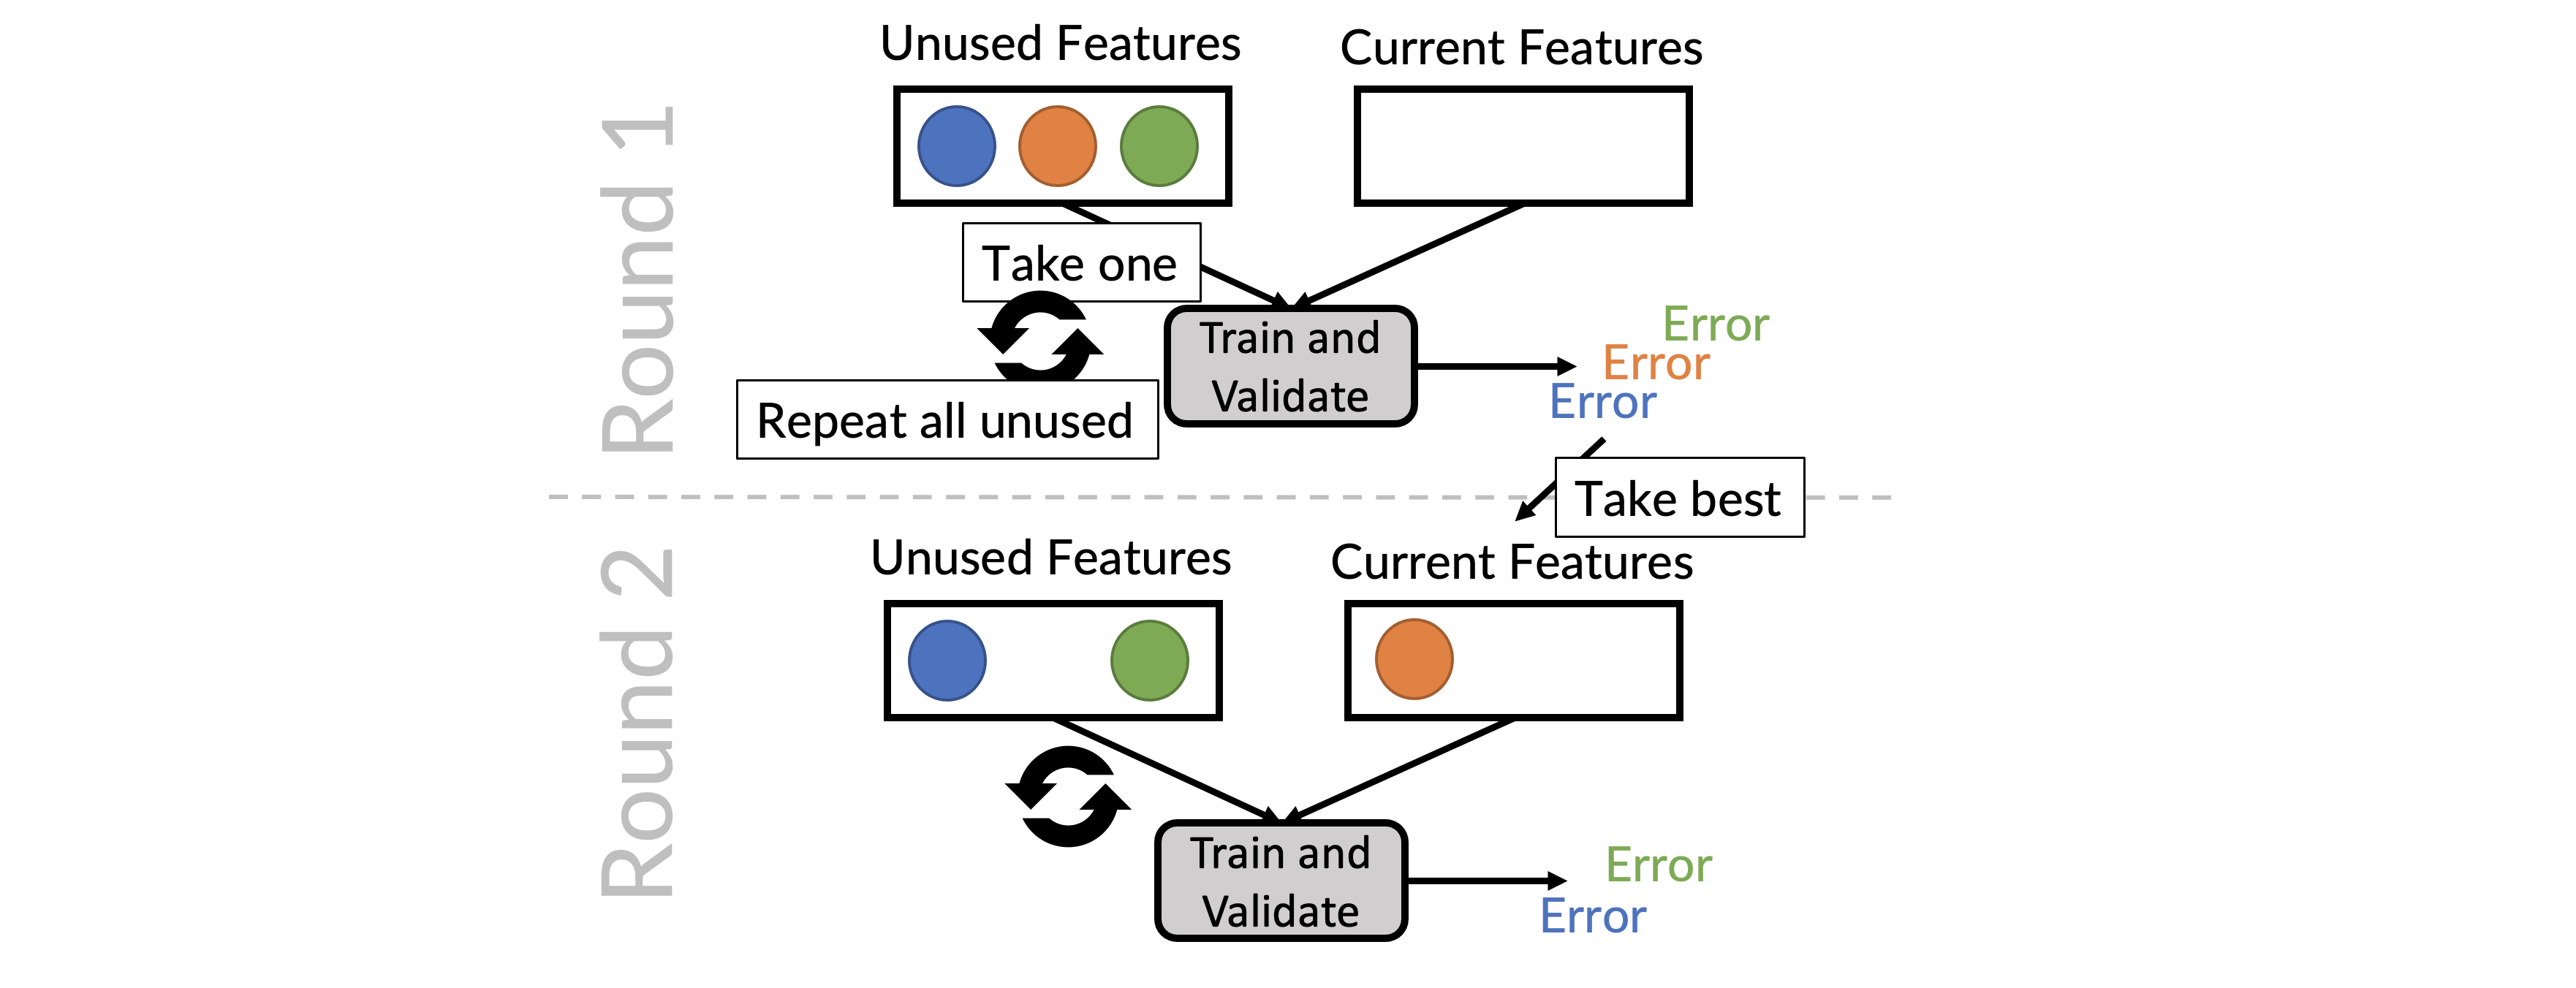

<font size=4>For comparison, let's use all features.

In [39]:
dev_X, dev_y = get_X_y(dev)
test_X, test_y = get_X_y(test)

In [40]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X_scaled = scaler.fit_transform(dev_X)
test_X_scaled = scaler.transform(test_X)

In [41]:
all_feat_model = sklearn.ensemble.RandomForestRegressor()
all_feat_model.fit(dev_X_scaled, dev_y)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_54080/2965669893.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  all_feat_model.fit(dev_X_scaled, dev_y)


RandomForestRegressor()

In [42]:
print(f"Model with all features MAE: {sklearn.metrics.mean_absolute_error(test_y, all_feat_model.predict(test_X_scaled))}")

Model with all features MAE: 0.20203510880371064


<font size=4>`sklearn` has forward selection built in

In [43]:
base_model = sklearn.ensemble.RandomForestRegressor()
selector = sklearn.feature_selection.SequentialFeatureSelector(
    base_model,
    n_features_to_select=5,
)

In [44]:
selector.fit(dev_X_scaled, dev_y)

/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ek/miniconda3/envs/DSMCER_general

SequentialFeatureSelector(estimator=RandomForestRegressor(),
                          n_features_to_select=5)

In [45]:
dev_X_5 = selector.transform(dev_X_scaled)
test_X_5 = selector.transform(test_X_scaled)

In [46]:
dev_X.shape

(424, 17)

<font size=4>How does a model using these features compare to all features?

In [47]:
five_feat_model = sklearn.ensemble.RandomForestRegressor()
five_feat_model.fit(dev_X_5, dev_y)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_54080/971874591.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  five_feat_model.fit(dev_X_5, dev_y)


RandomForestRegressor()

In [48]:
print(f"Model with all features MAE: {sklearn.metrics.mean_absolute_error(test_y, five_feat_model.predict(test_X_5))}")

Model with all features MAE: 0.2211037709168796


<font size=5><center>The model with 5/17 features almost as well as the model with all features. 

<font size=4> *Note*: intead of selected 5 features exactly, we can have the selector keep adding features __until the performance stops improving.__ See the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector).

### D. _Poll_: Forward selection disadvantages

<font size=4>The advantage of this method is that is won't get tripped up by nonlinear relationships between $X$ and $y$. Can you think of any disadvantages?

### E. By PCA

<font size=4>Remember features that we observed were highly correlated? Consider the following:

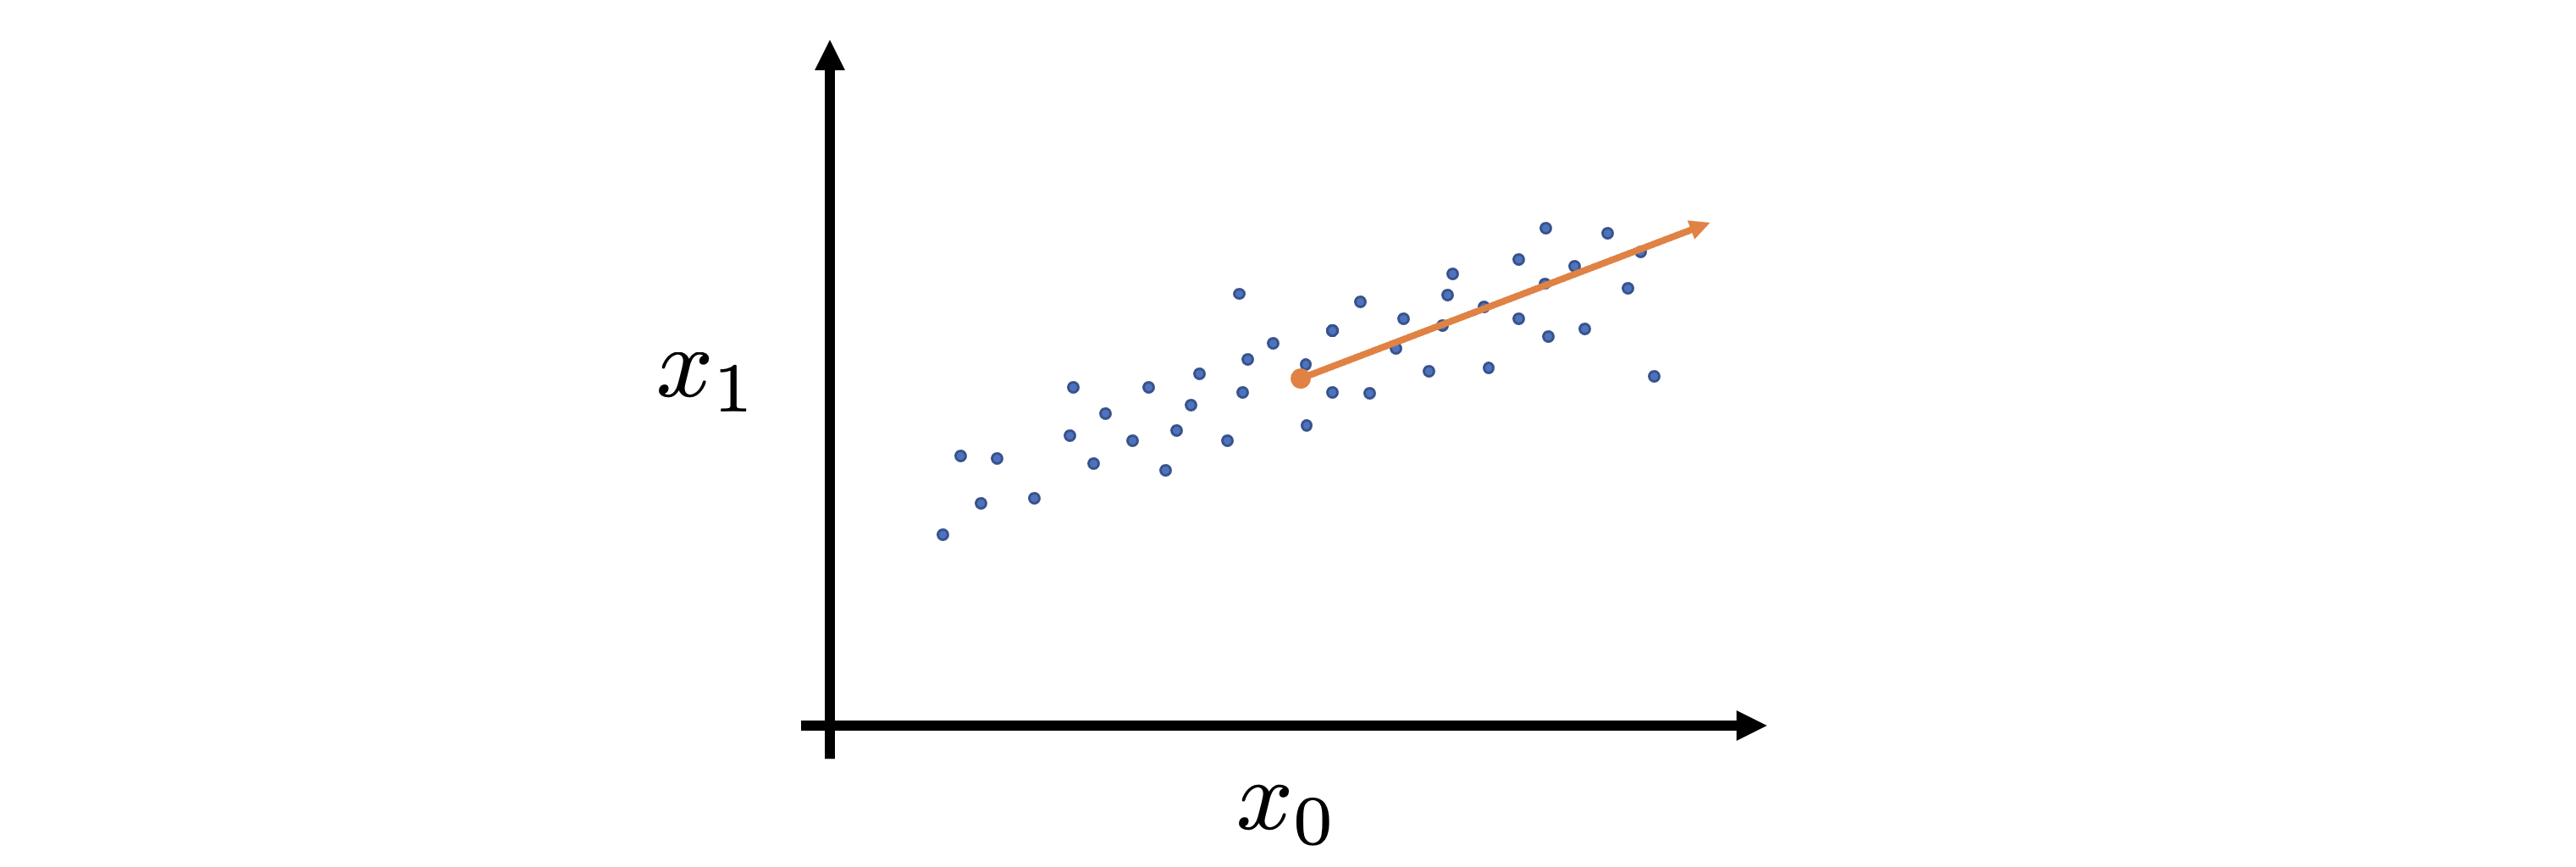

<font size=4>Instead of specifying the data with ($x_0$, $x_1$) pairs, what if we just used postition along the vector?

<font size=5><center>Principal Component Analysis (PCA) maps the data to __a lower dimensional space while maintaining as much information as possible__.

<font size=4>More technically, it finds the component (a linear combination of features) that captures the most variance. Then it repeats, finding an __orthoganol__ component that captures the next most variance.

<font size=4>The **first** principal component of our set of features $X = \left\{x_0,x_1,...,x_p\right\}$ is the linear combination

<font size=4>$$z_0 = \phi_{0,0}x_0 \,+\, \phi_{1,0}x_1 \,+\, ...\,+\,\phi_{p,0}x_p$$

<font size=4>__which has the largest variance__. The coefficients $\left\{\phi_{1,i}\right\}_{i=1}^{p}$ are called _loadings_ of the first principal component. The _loadings_ are such that $z_0$ is normalized, i.e. $\sum_i^p\phi_{i,0}^2=1$

<font size=4>The **second** principal component is the direction which maximizes variance among all directions orthogonal to the first. 

<font size=4>The $k$-th component is the variance-maximizing direction orthogonal to the previous $k − 1$ components.


<font size=5><center>But how do we find the loadings to maximize the variance?

<font size=4>This is a singular value decomposition optimization problem out of scope for this class. More info [here](https://en.wikipedia.org/wiki/Principal_component_analysis). __Note that is is critically important that the data are standardized__.

<font size=4>We can easilly implement PCA with sklearn:

In [63]:
pca = sklearn.decomposition.PCA(n_components=5)

# determine the PC's
dev_PCs = pca.fit_transform(dev_X_scaled)
test_PCs = pca.transform(test_X_scaled)

<font size=4>We can plot the first two principle, which should capture the first and second most variance:

Text(0.5, 1.0, 'PC1 vs y')

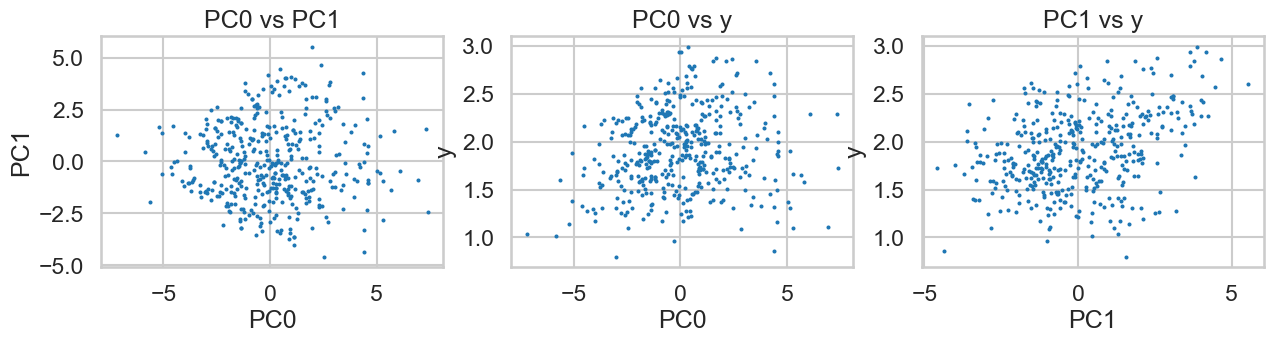

In [64]:
fig, axes = plt.subplots(1,3, figsize=(15,3))

axes[0].set_xlabel('PC0')
axes[0].set_ylabel('PC1')
axes[0].scatter(dev_PCs[:,0], dev_PCs[:,1], s=2)
axes[0].set_title('PC0 vs PC1')

axes[1].set_xlabel('PC0')
axes[1].set_ylabel('y')
axes[1].scatter(dev_PCs[:,0], dev_y, s=2)
axes[1].set_title('PC0 vs y')

axes[2].set_xlabel('PC1')
axes[2].set_ylabel('y')
axes[2].scatter(dev_PCs[:,1], dev_y, s=2)
axes[2].set_title('PC1 vs y')

<font size=5><center>__PCA allows to reduce our dimensionality to a new set of features__, and also confirmed to us that our set of features are weak features for the target of interest. ($^*$using standard ML models)

In [65]:
pca_model = sklearn.ensemble.RandomForestRegressor()
pca_model.fit(dev_PCs, dev_y)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_54080/3142435047.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pca_model.fit(dev_PCs, dev_y)


RandomForestRegressor()

In [66]:
print(f"Model with all features MAE: {sklearn.metrics.mean_absolute_error(test_y, pca_model.predict(test_PCs))}")

Model with all features MAE: 0.22413404601289466


<font size=4>Same performance as forward selecting 5 features without all of the brute force.

### F. _Exercise_: Interpretting the PCs

<font size=4>When we filtered, Lasso, or forward selected, the results were very interpretable - some specific features what we already computed were better than others. Can we interpret PCs?

<font size=4>Determine the amount of the total variance explained by these 5 principle components, as well as the original feature that contributes most heavily to the first PC.

> <span style='color:red'> remove for lec

In [69]:
pca.explained_variance_ratio_.sum()

0.8909387826608194

<font size=4>The 5 PCs explain 89% of the variance of the original 17 features.

In [77]:
pca.components_[0]

array([ 0.23116429, -0.27309654, -0.04514507, -0.29832263,  0.20869912,
        0.15769074,  0.27855218, -0.05947277, -0.3196151 , -0.3834347 ,
       -0.32806573, -0.04514507, -0.31517176, -0.0849605 , -0.23142966,
       -0.26221825, -0.20901209])

In [73]:
most_important_feat_index = np.argmax(np.abs(pca.components_[0]))

In [76]:
dev.columns[most_important_feat_index]

'x9'

<font size=4>$x_9$ contributes most to the first PC but it does not dominate.

<font size=5><center>When the features you start with are 